# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import (cross_val_score, 
                                     StratifiedKFold, 
                                     GridSearchCV)

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)

In [2]:
X_train = pd.read_csv('../data/x_train_processed.csv')
X_test = pd.read_csv('../data/x_test_processed.csv')
y_train = pd.read_csv('../data/y_train_processed.csv')
y_test = pd.read_csv('../data/y_test_processed.csv')

In [3]:
print(X_train.shape, '\n', 
      y_train.shape, '\n', 
      X_test.shape, '\n', 
      y_test.shape)

(8718, 31) 
 (8718, 1) 
 (2180, 31) 
 (2180, 1)


# RANDOM FOREST

In [4]:
cv = StratifiedKFold(n_splits=10,
                     random_state=73,
                     shuffle=True)

randfor_params = {'n_estimators': [600, 1000], 
                  'max_depth': [10, 50, None], 
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10]
                 }

# randfor_pipe = Pipeline([('ss', StandardScaler()),
#                          ('randfor', RandomForestClassifier(n_jobs=-1))
#                         ])

randfor_gridsearch = GridSearchCV(RandomForestClassifier(n_jobs=-1), 
                                  randfor_params, 
                                  cv=cv, 
                                  verbose=1, 
                                  n_jobs=-1)

randfor_gridsearch.fit(X_train, y_train.values.ravel())

print('Selected Parameters \n', 
      randfor_gridsearch.best_params_, '\n')
print('Baseline: 35% \n')
print('Best Score:', 
      round(randfor_gridsearch.best_score_, 4))
print('Test Score:', 
      round(randfor_gridsearch.score(X_test, y_test), 4))

Fitting 10 folds for each of 54 candidates, totalling 540 fits


/opt/homebrew/Caskroom/miniforge/base/envs/geo_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Selected Parameters 
 {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 600} 

Baseline: 35% 

Best Score: 0.5767
Test Score: 0.5968


### Random Forest Tuned Model

In [13]:
# Fitting Model
randfor = RandomForestClassifier(max_depth=randfor_gridsearch.best_params_['max_depth'], 
                                 n_estimators=randfor_gridsearch.best_params_['n_estimators'], 
                                 min_samples_leaf=randfor_gridsearch.best_params_['min_samples_leaf'], 
                                 min_samples_split=randfor_gridsearch.best_params_['min_samples_split'], 
                                random_state=23)
randfor.fit(X_train, y_train.values.ravel())

train_scores = cross_val_score(randfor, X_train, y_train.values.ravel())
test_scores = cross_val_score(randfor, X_test, y_test.values.ravel())

print('Baseline: 35% \n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 35% 

Train scores: [0.58772936 0.5728211  0.56651376 0.56626506 0.58347676]
Mean: 0.575
Stdev: 0.018 

Test scores: [0.56651376 0.60779817 0.58256881 0.55733945 0.58256881]
Mean: 0.579
Stdev: 0.034 



# METRICS

              precision    recall  f1-score   support

      0-11hr       0.67      0.71      0.69       737
     11-32hr       0.47      0.35      0.40       695
32hours-7day       0.62      0.72      0.67       748

    accuracy                           0.60      2180
   macro avg       0.59      0.60      0.59      2180
weighted avg       0.59      0.60      0.59      2180



''

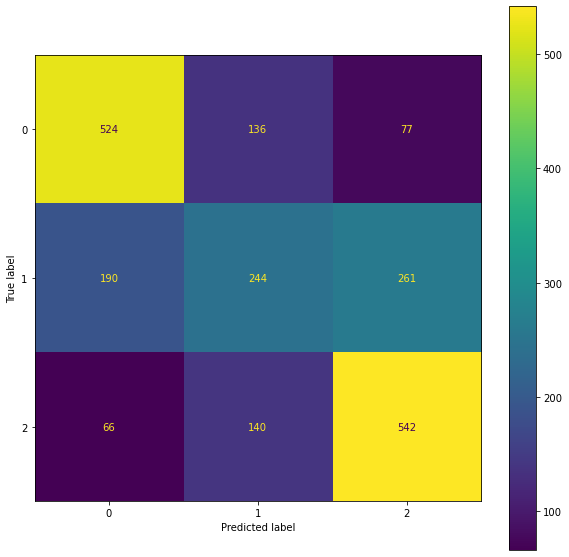

In [14]:
conmat = np.array(confusion_matrix(y_test, 
                                   randfor.predict(X_test), 
                                   labels=[0,1,2]))

print(classification_report(y_test,
                            randfor.predict(X_test), 
                            target_names=['0-11hr', '11-32hr', '32hours-7day']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=randfor.classes_)
matrix_display.plot()

figure = plt.gcf()
figure.set_size_inches(10, 10)
;

# Feature Importance

In [7]:
randfor_importance = pd.DataFrame(data=randfor.feature_importances_, 
             columns=['importance'], 
             index=X_train.columns).sort_values(by='importance', ascending=False)

randfor_importance.head(10)

,importance
number_volunteers,0.635167
number_subjects,0.039271
aircrafts_1,0.037427
state_California,0.024610
state_Colorado,0.024448
state_Pennsylvania,0.024361
daylight,0.024197
area_type_urban_rural,0.021688
winter,0.021511
state_Utah,0.019725


# Analysis

**Metrics**
- Overall the model is 60% accurate in predicting the target class. This is 25% more than the baseline model with a probability of 35%. 
- The model had the most precision in predicting the 1st class - (0-11hours), followed closely by the third class (32hours-7days)

**Feature Importance**
- The model gave the most importance the the only continuous variable that we included `number_volunteers`, followed by `number_subjects`. The later feature was treated as a continous variabel, though it's range was limited to 1-10 subjects. 
- `aircraft_1` was the third most important feature. This dummy variable indicates that there was 1 type of aircraft used, most likely a helicopter. 
- `state_california` was the 4th most important feature. California was the state that had the most incidents, and coinsidentally a lower average `total_hours` (roughly 23).
- `daylight` were the 7th most important features. 
- `area_type_urban_rural` and `winter` also were among the top 10 most important features. These features combined comprised 5% of the feature importance. 

**Conclusion**

This model is slightly more accurate in predicting the target class compared to the Logistic Regression model. Because the Logistic Regression model does have a higher level of human interpretability, I would recommend implementing the Logistic Regression model into production rather than this Random Forest Model. The Logistic Regression model also has the added benefit of incorporating Lasso, which we eliminates features that mostly capture noise rather than signal. 